
    train_set and test_set contain information on price quotes from suppliers. Prices can be quoted in 2 ways: bracket and non-bracket pricing. Bracket pricing has multiple levels of purchase based on quantity (in other words, the cost is given assuming a purchase of quantity tubes). Non-bracket pricing has a minimum order amount (min_order) for which the price would apply. Each quote is issued with an annual_usage, an estimate of how many tube assemblies will be purchased in a given year;
    tube contains information on physical parameters of tube assemblies;
    
    bill_of_materials contains the list of components, and their quantities, used on each tube assembly;
    specs contains the list of unique specifications for the tube assembly;
    tube_end_form contains list of end types which are physically formed utilizing only the wall of the tube;
    components contains the list of all of the components used;
    type... contain the names for each feature;
    comp... contains information on physical parameters of components by their type;


In [75]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#Read each file in a separate data frame.
bill_of_materials = pd.read_csv('./data/bill_of_materials.csv')
components = pd.read_csv('./data/components.csv')
comp_adaptor = pd.read_csv('./data/comp_adaptor.csv')
comp_boss = pd.read_csv('./data/comp_boss.csv')
comp_elbow = pd.read_csv('./data/comp_elbow.csv')
comp_float = pd.read_csv('./data/comp_float.csv')
comp_hfl = pd.read_csv('./data/comp_hfl.csv')
comp_nut = pd.read_csv('./data/comp_nut.csv')
comp_other = pd.read_csv('./data/comp_other.csv')
comp_sleeve = pd.read_csv('./data/comp_sleeve.csv')
comp_straight = pd.read_csv('./data/comp_straight.csv')
comp_tee = pd.read_csv('./data/comp_tee.csv')
comp_threaded = pd.read_csv('./data/comp_threaded.csv')
specs = pd.read_csv('./data/specs.csv')
tube = pd.read_csv('./data/tube.csv')
tube_end_form = pd.read_csv('./data/tube_end_form.csv')
type_component = pd.read_csv('./data/type_component.csv')
type_connection = pd.read_csv('./data/type_connection.csv')
type_end_form = pd.read_csv('./data/type_end_form.csv')
train = pd.read_csv('./data/train_set.csv', parse_dates=[2,])
test = pd.read_csv('./data/test_set.csv', parse_dates=[3,])


In [3]:
print(bill_of_materials.shape)
bill_of_materials.head()

(21198, 17)


,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
bill_of_materials.isnull().sum()

tube_assembly_id        0
component_id_1       2049
quantity_1           2049
component_id_2       6412
quantity_2           6412
component_id_3      16407
quantity_3          16400
component_id_4      20591
quantity_4          20590
component_id_5      21106
quantity_5          21106
component_id_6      21172
quantity_6          21172
component_id_7      21191
quantity_7          21191
component_id_8      21197
quantity_8          21197
dtype: int64

In [5]:
print(comp_adaptor.shape)
comp_adaptor



(25, 20)


,component_id,component_type_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,connection_type_id_2,length_2,thread_size_2,thread_pitch_2,nominal_size_2,hex_size,unique_feature,orientation,weight
0,C-0005,CP-028,NaN,58.40,A-001,B-001,NaN,1.312,12.0,NaN,A-001,B-004,NaN,1.000,11.5,NaN,34.93,No,No,0.206
1,C-0006,CP-028,NaN,34.80,A-001,B-001,NaN,0.437,20.0,NaN,A-001,B-005,NaN,0.750,16.0,NaN,22.20,No,No,0.083
2,C-1435,CP-028,NaN,20.30,A-007,B-004,NaN,NaN,NaN,15.88,A-001,B-007,NaN,0.875,18.0,NaN,22.22,No,No,0.023
3,C-1546,CP-028,NaN,26.40,A-007,B-004,NaN,0.125,27.0,NaN,A-001,B-004,NaN,0.125,27.0,NaN,15.88,No,No,0.026
4,C-1583,CP-028,NaN,44.50,A-001,B-005,NaN,1.312,12.0,NaN,A-007,B-005,NaN,1.062,12.0,NaN,38.10,No,No,0.256
5,C-1634,CP-028,NaN,34.50,A-001,B-005,NaN,0.750,16.0,NaN,A-001,B-002,NaN,0.687,16.0,NaN,22.23,No,No,0.060
6,C-1975,CP-028,NaN,13.20,A-007,B-007,NaN,NaN,NaN,3.18,A-001,B-007,NaN,0.312,28.0,NaN,NaN,No,No,0.005
7,C-0428,CP-028,NaN,26.99,A-001,B-004,NaN,0.250,18.0,NaN,A-007,NaN,NaN,NaN,NaN,9.52,17.46,No,No,0.032
8,C-0443,CP-028,NaN,22.35,A-007,B-007,NaN,NaN,NaN,19.05,9999,9999,NaN,1.062,16.0,NaN,26.97,No,No,NaN
9,C-0823,CP-028,NaN,16.80,A-007,B-007,NaN,NaN,NaN,9.52,A-001,9999,NaN,0.625,18.0,9.52,15.75,No,No,0.014


In [6]:
comp_adaptor.isnull().sum()

component_id             0
component_type_id        0
adaptor_angle           24
overall_length           1
end_form_id_1            0
connection_type_id_1     1
length_1                24
thread_size_1            8
thread_pitch_1           8
nominal_size_1          17
end_form_id_2            0
connection_type_id_2     1
length_2                24
thread_size_2            2
thread_pitch_2           2
nominal_size_2          23
hex_size                 8
unique_feature           0
orientation              0
weight                   2
dtype: int64

In [7]:


# component_type_id, end_form_id_1, connection_type_id_1, end_form_id_2, connection_type_id_2, it is useless in all files.

# adaptor_angle - only one value. 

# unique_feature, orientation - categorical description. 

# C-1695 has abnormal values. And only one tube assembly has it. So I'll drop it.

# C-0443 has NaN weight. And it belongs to only one tube assembly, which has two components, both with NaN weight. So drop.

# C-1868. It seems that for some reason overall_length wasn't calculated. I'll calculate it as a sum of length_1 and length_2. Drop length_1 and length_2 after using becasue it of 
#no use now


comp_adaptor.drop(['adaptor_angle', 'component_type_id', 'end_form_id_1', 'connection_type_id_1', 'length_1', 'length_2',
                   'unique_feature', 'orientation', 'end_form_id_2', 'connection_type_id_2'], axis=1, inplace=True)

#Could input a formula, but it single value.
comp_adaptor.loc[comp_adaptor['overall_length'].isnull(), 'overall_length'] = 93.5
comp_adaptor.drop(comp_adaptor.index[[8, 21]], inplace=True)
print(comp_adaptor.shape)
comp_adaptor

(23, 10)


,component_id,overall_length,thread_size_1,thread_pitch_1,nominal_size_1,thread_size_2,thread_pitch_2,nominal_size_2,hex_size,weight
0,C-0005,58.40,1.312,12.0,NaN,1.000,11.5,NaN,34.93,0.206
1,C-0006,34.80,0.437,20.0,NaN,0.750,16.0,NaN,22.20,0.083
2,C-1435,20.30,NaN,NaN,15.88,0.875,18.0,NaN,22.22,0.023
3,C-1546,26.40,0.125,27.0,NaN,0.125,27.0,NaN,15.88,0.026
4,C-1583,44.50,1.312,12.0,NaN,1.062,12.0,NaN,38.10,0.256
5,C-1634,34.50,0.750,16.0,NaN,0.687,16.0,NaN,22.23,0.060
6,C-1975,13.20,NaN,NaN,3.18,0.312,28.0,NaN,NaN,0.005
7,C-0428,26.99,0.250,18.0,NaN,NaN,NaN,9.52,17.46,0.032
9,C-0823,16.80,NaN,NaN,9.52,0.625,18.0,9.52,15.75,0.014
10,C-0354,36.30,1.250,11.5,NaN,1.000,11.5,NaN,44.45,0.136


In [8]:
print(comp_boss.shape)
comp_boss.head()

(147, 15)


,component_id,component_type_id,type,connection_type_id,outside_shape,base_type,height_over_tube,bolt_pattern_long,bolt_pattern_wide,groove,base_diameter,shoulder_diameter,unique_feature,orientation,weight
0,C-0008,CP-018,Boss,B-005,Round,Flat Bottom,17.0,NaN,NaN,No,22.0,NaN,Yes,Yes,0.032
1,C-0009,CP-018,Boss,B-004,Round,Flat Bottom,13.0,NaN,NaN,No,25.0,NaN,No,Yes,0.033
2,C-0020,CP-018,Boss,B-005,Round,Saddle,28.4,NaN,NaN,No,35.0,NaN,Yes,Yes,0.070
3,C-0054,CP-018,Boss,B-005,Round,Saddle,27.1,NaN,NaN,No,NaN,NaN,Yes,Yes,0.180
4,C-0071,CP-018,Boss,B-005,Round,Shoulder,20.0,NaN,NaN,No,30.0,23.0,Yes,Yes,0.080


In [9]:
comp_boss.isnull().sum()

component_id            0
component_type_id       0
type                   23
connection_type_id      0
outside_shape          23
base_type              23
height_over_tube        0
bolt_pattern_long     124
bolt_pattern_wide     130
groove                  0
base_diameter          90
shoulder_diameter     117
unique_feature          0
orientation             0
weight                  2
dtype: int64

In [10]:
#Use only important information.
comp_boss = comp_boss[['component_id', 'height_over_tube', 'weight']]
comp_boss.head()

,component_id,height_over_tube,weight
0,C-0008,17.0,0.032
1,C-0009,13.0,0.033
2,C-0020,28.4,0.070
3,C-0054,27.1,0.180
4,C-0071,20.0,0.080


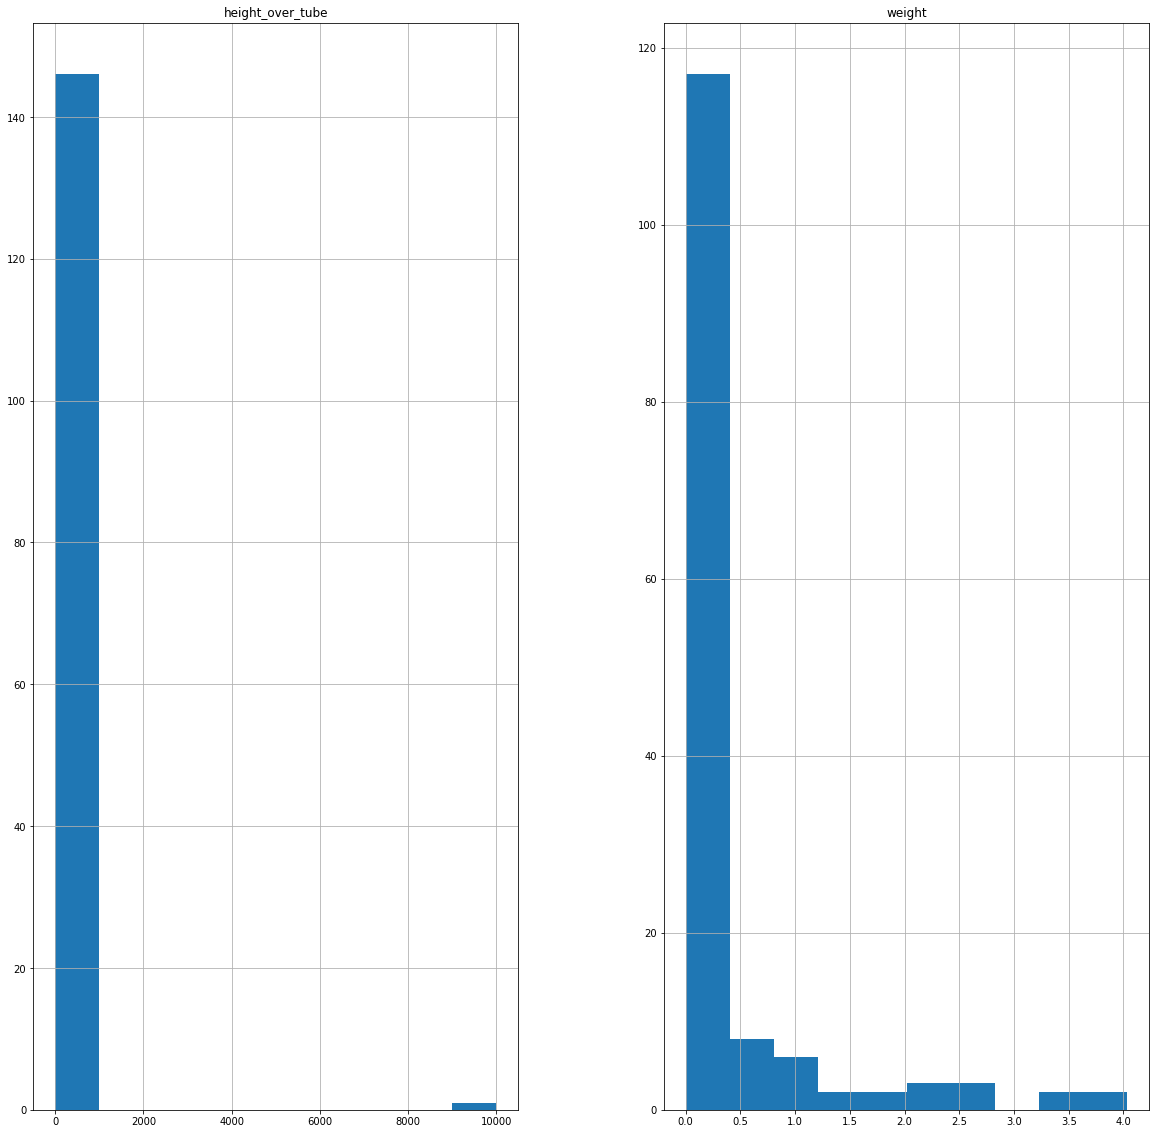

In [11]:
comp_boss.hist(figsize=(20,20))
plt.show()

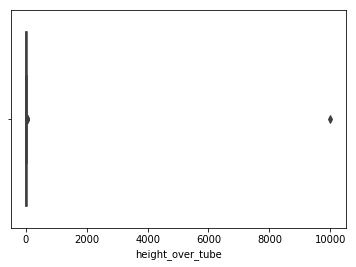

In [12]:
import seaborn as sns
sns.boxplot(x=comp_boss["height_over_tube"])

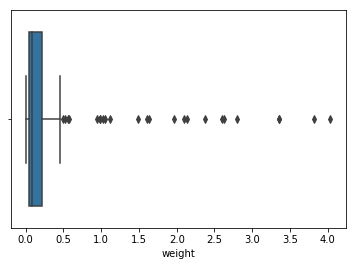

In [13]:
sns.boxplot(x=comp_boss["weight"])

In [14]:
#outlier detection through IQR proximity rule as the distribution is skewed

for i in comp_boss.columns:
    if comp_boss[i].dtype != object:
        IQR = comp_boss[i].quantile(0.75)-comp_boss[i].quantile(0.25)
        upperThres = comp_boss[i].quantile(0.75)+3*IQR
        print()
        print(upperThres)
        if comp_boss[i][comp_boss[i] > upperThres].any() == True:
            print(i)
            print(comp_boss.loc[comp_boss[i] == comp_boss[i].max()])




49.275000000000006
height_over_tube
   component_id  height_over_tube  weight
31       C-0307            9999.0    1.05

0.7179999999999999
weight
   component_id  height_over_tube  weight
21       C-0243              36.0   4.034


In [15]:
comp_boss.drop(comp_boss.index[31], inplace=True)
comp_boss.head()

,component_id,height_over_tube,weight
0,C-0008,17.0,0.032
1,C-0009,13.0,0.033
2,C-0020,28.4,0.070
3,C-0054,27.1,0.180
4,C-0071,20.0,0.080


In [16]:
comp_hfl.head()

,component_id,component_type_id,hose_diameter,corresponding_shell,coupling_class,material,plating,orientation,weight
0,C-0872,CP-023,4.8,C-0855,SP-0098,SP-0016,Yes,No,0.010
1,C-0873,CP-023,4.8,C-0856,SP-0098,SP-0016,Yes,No,0.010
2,C-0874,CP-023,4.8,C-0857,SP-0098,SP-0038,Yes,No,0.001
3,C-1039,CP-023,15.9,C-1040,SP-0097,SP-0095,No,No,0.052
4,C-1041,CP-023,15.9,C-1042,SP-0099,SP-0095,No,No,0.065


In [17]:
#take only the useful columns
comp_hfl = comp_hfl[['component_id', 'hose_diameter', 'weight']]
comp_hfl

,component_id,hose_diameter,weight
0,C-0872,4.8,0.010
1,C-0873,4.8,0.010
2,C-0874,4.8,0.001
3,C-1039,15.9,0.052
4,C-1041,15.9,0.065
5,C-1043,25.4,0.196


In [18]:
comp_elbow.head()

,component_id,component_type_id,bolt_pattern_long,bolt_pattern_wide,extension_length,overall_length,thickness,drop_length,elbow_angle,mj_class_code,mj_plug_class_code,plug_diameter,groove,unique_feature,orientation,weight
0,C-0013,CP-008,152.4,92.08,105.0,185.0,113.0,75.0,90.0,NaN,NaN,NaN,Yes,No,Yes,8.890
1,C-0016,CP-009,57.2,27.80,42.0,69.0,44.0,24.0,90.0,NaN,NaN,NaN,No,No,Yes,1.172
2,C-0017,CP-009,57.2,27.80,42.0,69.0,47.0,26.0,90.0,NaN,NaN,NaN,Yes,No,Yes,1.245
3,C-0018,CP-009,66.6,31.80,50.0,80.0,57.0,31.5,90.0,NaN,NaN,NaN,Yes,No,Yes,1.863
4,C-0021,CP-010,75.0,NaN,31.5,70.0,25.0,12.5,90.0,NaN,NaN,NaN,No,Yes,Yes,0.903


In [19]:


#Most of the columns aren't necessary.
comp_elbow.drop(['component_type_id', 'mj_class_code', 'mj_plug_class_code', 'plug_diameter', 'groove', 'unique_feature',
                 'orientation',], axis=1, inplace=True)

comp_elbow.head()

,component_id,bolt_pattern_long,bolt_pattern_wide,extension_length,overall_length,thickness,drop_length,elbow_angle,weight
0,C-0013,152.4,92.08,105.0,185.0,113.0,75.0,90.0,8.890
1,C-0016,57.2,27.80,42.0,69.0,44.0,24.0,90.0,1.172
2,C-0017,57.2,27.80,42.0,69.0,47.0,26.0,90.0,1.245
3,C-0018,66.6,31.80,50.0,80.0,57.0,31.5,90.0,1.863
4,C-0021,75.0,NaN,31.5,70.0,25.0,12.5,90.0,0.903


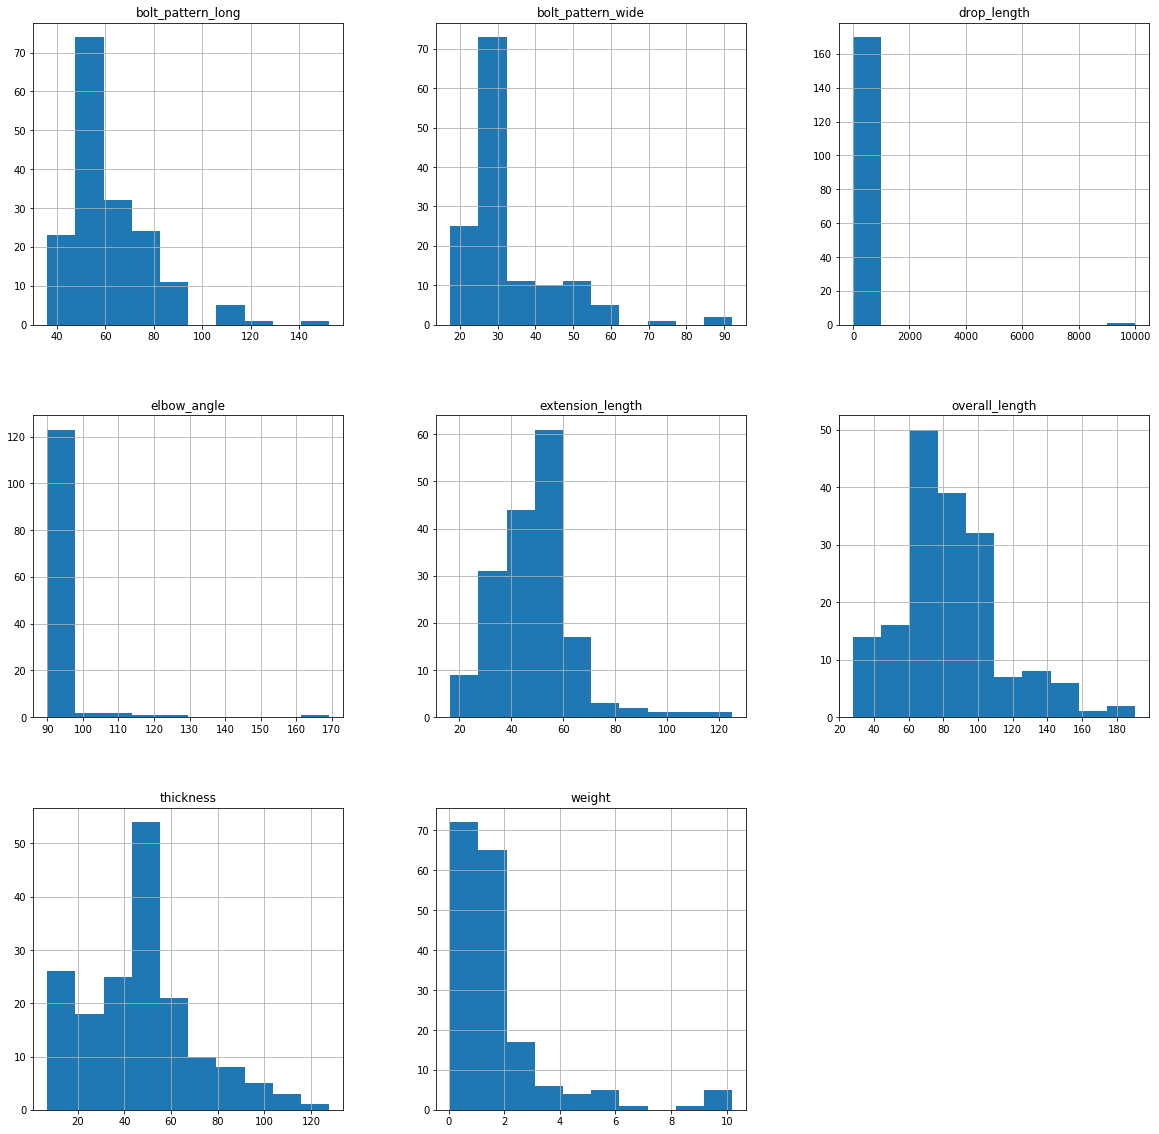

In [20]:
comp_elbow.hist(figsize=(20,20))
plt.show()

In [21]:
#outlier detection through IQR proximity rule as the distribution is skewed

for i in comp_elbow.columns:
    if comp_elbow[i].dtype != object:
        IQR = comp_elbow[i].quantile(0.75)-comp_elbow[i].quantile(0.25)
        upperThres = comp_elbow[i].quantile(0.75)+3*IQR
      
        if comp_elbow[i][comp_elbow[i] > upperThres].any() == True:
            print(i)
            print(comp_elbow.loc[comp_elbow[i] == comp_elbow[i].max()])



bolt_pattern_long
  component_id  bolt_pattern_long  bolt_pattern_wide  extension_length  \
0       C-0013              152.4              92.08             105.0   

   overall_length  thickness  drop_length  elbow_angle  weight  
0           185.0      113.0         75.0         90.0    8.89  
bolt_pattern_wide
  component_id  bolt_pattern_long  bolt_pattern_wide  extension_length  \
0       C-0013              152.4              92.08             105.0   

   overall_length  thickness  drop_length  elbow_angle  weight  
0           185.0      113.0         75.0         90.0    8.89  
extension_length
   component_id  bolt_pattern_long  bolt_pattern_wide  extension_length  \
26       C-0169             106.38              61.93             125.0   

    overall_length  thickness  drop_length  elbow_angle  weight  
26          190.55      127.7        100.0         90.0   9.805  
drop_length
   component_id  bolt_pattern_long  bolt_pattern_wide  extension_length  \
52       C-0537    

In [22]:
comp_elbow.drop(comp_elbow.index[52], inplace=True)

In [23]:
comp_float.head()

,component_id,component_type_id,bolt_pattern_long,bolt_pattern_wide,thickness,orientation,weight
0,C-0027,CP-021,148.00,96.00,18.00,Yes,2.230
1,C-0454,CP-022,58.72,30.18,28.00,No,0.590
2,C-0455,CP-022,58.72,30.18,28.00,No,0.525
3,C-0494,CP-022,52.40,26.20,15.85,No,0.230
4,C-0496,CP-022,58.80,30.20,14.20,No,0.284


In [24]:
#Drop not required columns.
comp_float.drop(['component_type_id', 'orientation'], axis=1, inplace=True)
comp_float

,component_id,bolt_pattern_long,bolt_pattern_wide,thickness,weight
0,C-0027,148.00,96.00,18.00,2.230
1,C-0454,58.72,30.18,28.00,0.590
2,C-0455,58.72,30.18,28.00,0.525
3,C-0494,52.40,26.20,15.85,0.230
4,C-0496,58.80,30.20,14.20,0.284
5,C-0508,77.76,42.88,25.40,1.144
6,C-0572,69.85,35.71,15.70,0.447
7,C-0797,120.65,69.85,20.00,1.983
8,C-0891,47.62,22.22,28.00,0.465
9,C-1096,76.40,69.90,25.00,2.565


In [25]:
comp_nut.head()

,component_id,component_type_id,hex_nut_size,seat_angle,length,thread_size,thread_pitch,diameter,blind_hole,orientation,weight
0,C-1621,CP-025,20.64,NaN,17.0,.687,16.0,NaN,NaN,No,0.015
1,C-1624,CP-025,34.92,NaN,26.5,1.187,12.0,NaN,NaN,No,0.035
2,C-1623,CP-025,28.58,NaN,23.5,1.000,14.0,NaN,NaN,No,0.044
3,C-1622,CP-025,23.81,NaN,20.0,.812,16.0,NaN,NaN,No,0.036
4,C-1625,CP-025,41.28,NaN,27.5,1.437,12.0,NaN,NaN,No,0.129


In [26]:
comp_nut.drop(['component_type_id', 'seat_angle', 'diameter', 'blind_hole', 'orientation'], axis=1, inplace=True)
comp_nut.head()

,component_id,hex_nut_size,length,thread_size,thread_pitch,weight
0,C-1621,20.64,17.0,.687,16.0,0.015
1,C-1624,34.92,26.5,1.187,12.0,0.035
2,C-1623,28.58,23.5,1.000,14.0,0.044
3,C-1622,23.81,20.0,.812,16.0,0.036
4,C-1625,41.28,27.5,1.437,12.0,0.129


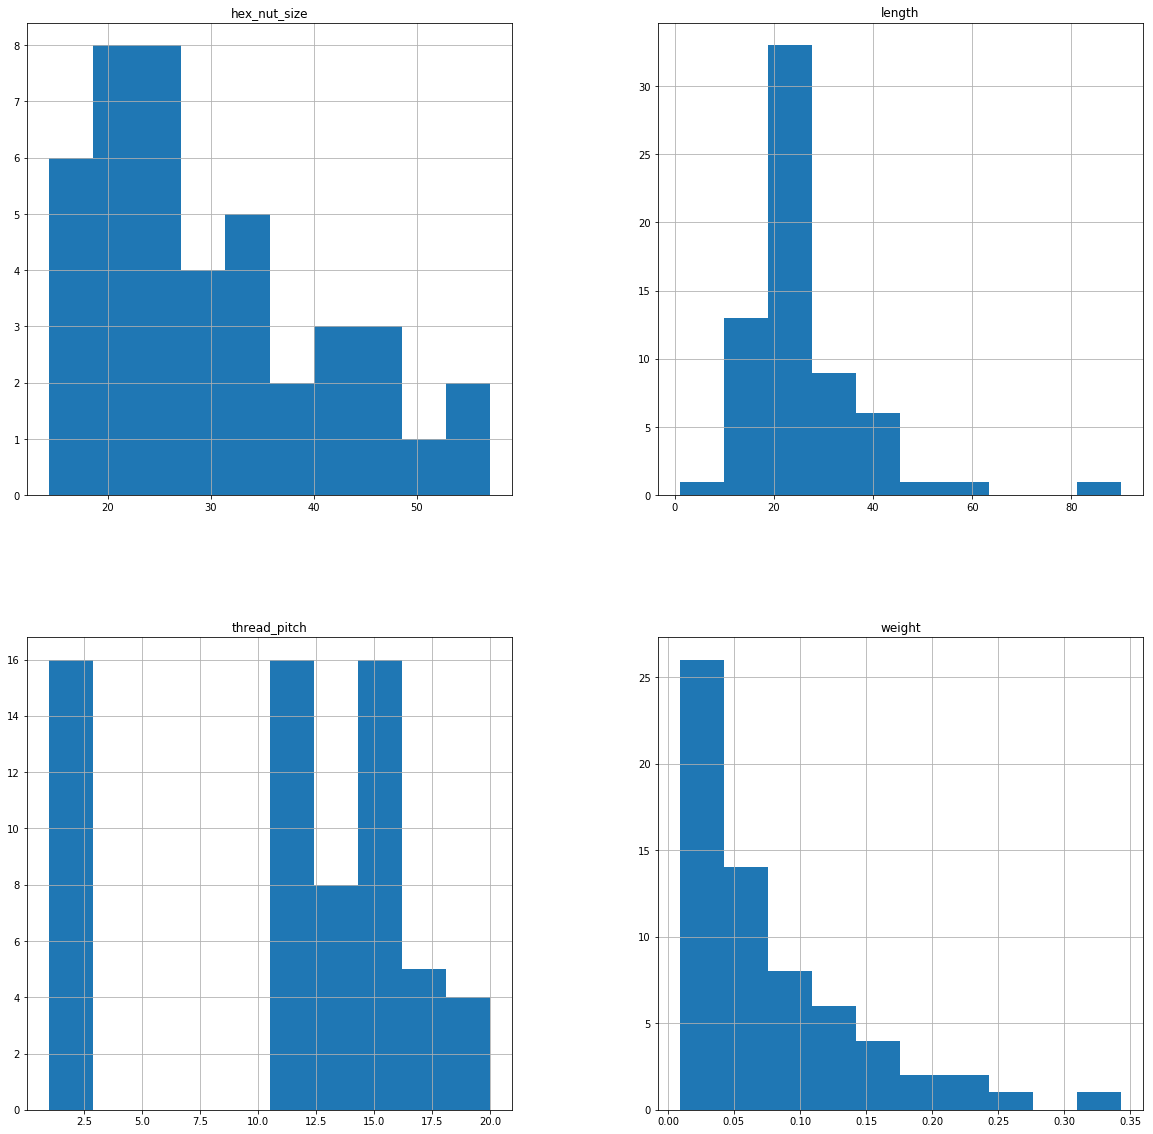

In [27]:
comp_nut.hist(figsize=(20,20))
plt.show()

In [28]:
#outlier detection through IQR proximity rule as the distribution is skewed

for i in comp_nut.columns:
    if comp_nut[i].dtype != object:
        IQR = comp_nut[i].quantile(0.75)-comp_nut[i].quantile(0.25)
        upperThres = comp_nut[i].quantile(0.75)+3*IQR
        
        if comp_nut[i][comp_nut[i] > upperThres].any() == True:
            print(i)
            print(comp_nut.loc[comp_nut[i] == comp_nut[i].max()])



length
   component_id  hex_nut_size  length thread_size  thread_pitch  weight
49       C-0720           NaN    90.0         M12          1.75   0.222


In [29]:
comp_other.head()

,component_id,part_name,weight
0,C-1385,NUT-FLARED,0.014
1,C-1386,SLEEVE-FLARED,0.005
2,C-1369,COLLAR,0.003
3,C-0422,WASHER-FUEL LIN,0.003
4,C-1817,FITTING-NUT,0.014


In [30]:


#Dtop part_name
comp_other.drop(['part_name'], axis=1, inplace=True)
comp_other.head()



,component_id,weight
0,C-1385,0.014
1,C-1386,0.005
2,C-1369,0.003
3,C-0422,0.003
4,C-1817,0.014


In [31]:
comp_sleeve.head()

,component_id,component_type_id,connection_type_id,length,intended_nut_thread,intended_nut_pitch,unique_feature,plating,orientation,weight
0,C-0001,CP-024,B-001,17.3,1.062,12,No,No,No,0.013
1,C-0002,CP-024,B-001,11.2,0.500,20,No,No,No,0.005
2,C-0003,CP-024,B-001,19.3,1.187,12,No,No,No,0.014
3,C-0048,CP-024,B-002,9.5,0.562,18,No,No,No,0.006
4,C-0049,CP-024,B-002,9.5,0.812,16,No,No,No,0.012


In [32]:
comp_sleeve.drop(['component_type_id', 'connection_type_id', 'unique_feature', 'plating', 'orientation'], axis=1, inplace=True)
comp_sleeve.head()

,component_id,length,intended_nut_thread,intended_nut_pitch,weight
0,C-0001,17.3,1.062,12,0.013
1,C-0002,11.2,0.500,20,0.005
2,C-0003,19.3,1.187,12,0.014
3,C-0048,9.5,0.562,18,0.006
4,C-0049,9.5,0.812,16,0.012


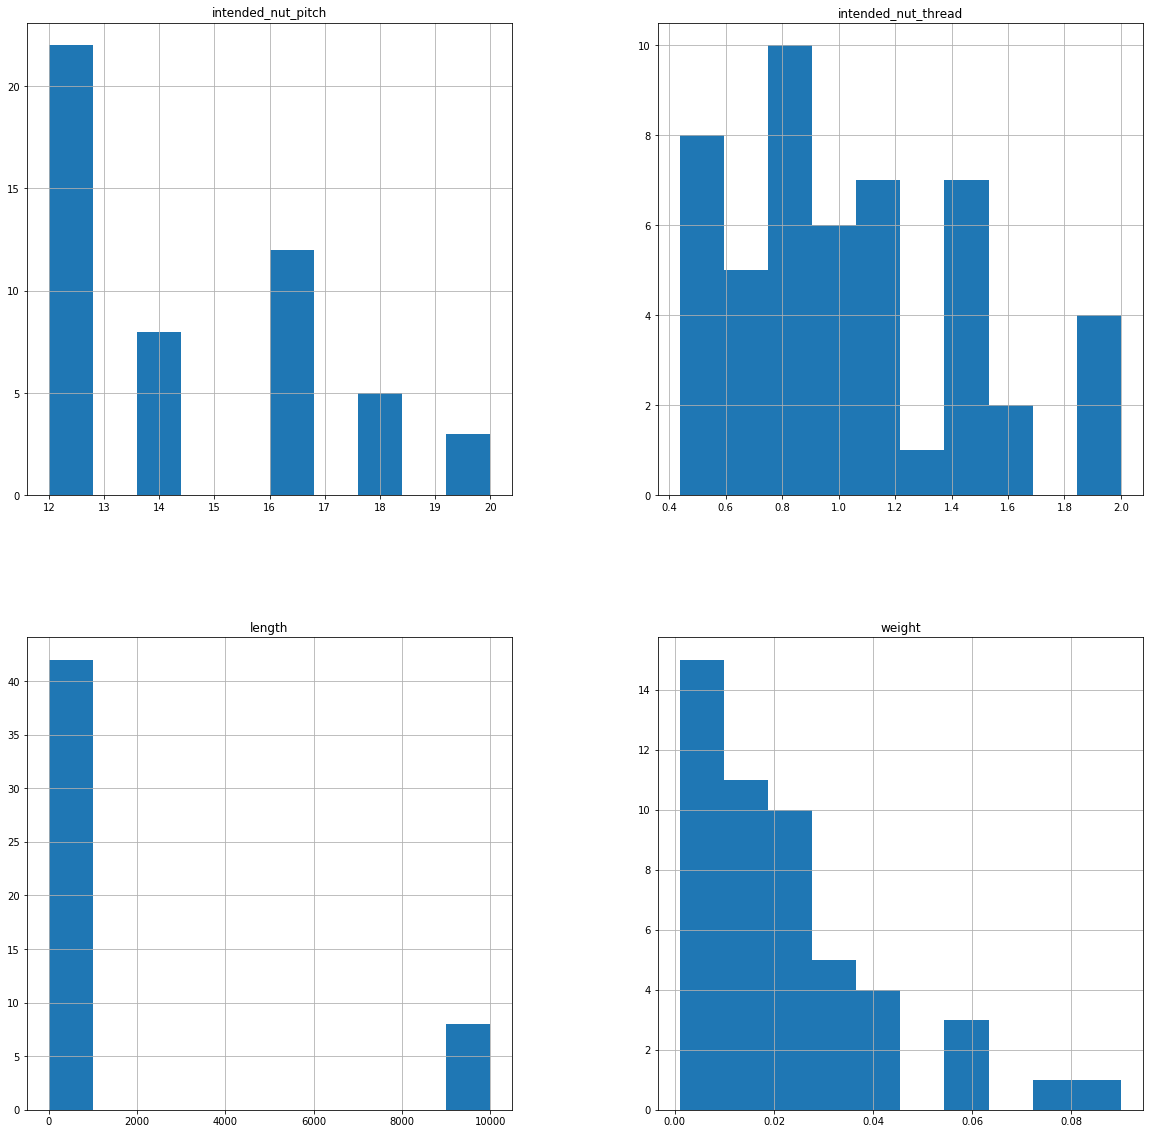

In [33]:
comp_sleeve.hist(figsize=(20,20))
plt.show()

In [34]:
#outlier detection through IQR proximity rule as the distribution is skewed

for i in comp_sleeve.columns:
    if comp_sleeve[i].dtype != object:
        IQR = comp_sleeve[i].quantile(0.75)-comp_sleeve[i].quantile(0.25)
        upperThres = comp_sleeve[i].quantile(0.75)+3*IQR
        
        if comp_sleeve[i][comp_sleeve[i] > upperThres].any() == True:
            print(i)
            print(comp_sleeve.loc[comp_sleeve[i] == comp_sleeve[i].max()])



length
   component_id  length  intended_nut_thread  intended_nut_pitch  weight
28       C-1627  9999.0                0.562                  18   0.005
29       C-1628  9999.0                0.687                  16   0.006
30       C-1629  9999.0                0.812                  16   0.012
31       C-1630  9999.0                1.000                  14   0.018
32       C-1631  9999.0                1.187                  12   0.026
33       C-1632  9999.0                1.437                  12   0.033
34       C-1633  9999.0                1.687                  12   0.040
48       C-1866  9999.0                2.000                  12   0.035


In [35]:
comp_sleeve.drop(comp_sleeve.index[[28, 29, 30, 31, 32, 33, 34, 48]], inplace=True)

In [36]:
comp_straight.head()

,component_id,component_type_id,bolt_pattern_long,bolt_pattern_wide,head_diameter,overall_length,thickness,mj_class_code,groove,unique_feature,orientation,weight
0,C-0012,CP-001,66.68,31.75,NaN,40.0,20.0,NaN,No,No,Yes,0.788
1,C-0014,CP-001,47.60,22.20,NaN,38.0,15.0,NaN,Yes,No,Yes,0.339
2,C-0015,CP-001,66.70,31.80,NaN,40.0,20.0,NaN,Yes,No,Yes,0.788
3,C-0019,CP-002,77.80,42.90,NaN,NaN,36.5,MJ-003,No,No,Yes,1.533
4,C-0029,CP-001,47.63,22.23,NaN,NaN,16.0,NaN,Yes,No,Yes,0.286


In [37]:
comp_straight.drop(['component_type_id', 'overall_length', 'mj_class_code', 'head_diameter', 'unique_feature', 'groove',
                    'orientation'], axis=1, inplace=True)
comp_straight.head()

,component_id,bolt_pattern_long,bolt_pattern_wide,thickness,weight
0,C-0012,66.68,31.75,20.0,0.788
1,C-0014,47.60,22.20,15.0,0.339
2,C-0015,66.70,31.80,20.0,0.788
3,C-0019,77.80,42.90,36.5,1.533
4,C-0029,47.63,22.23,16.0,0.286


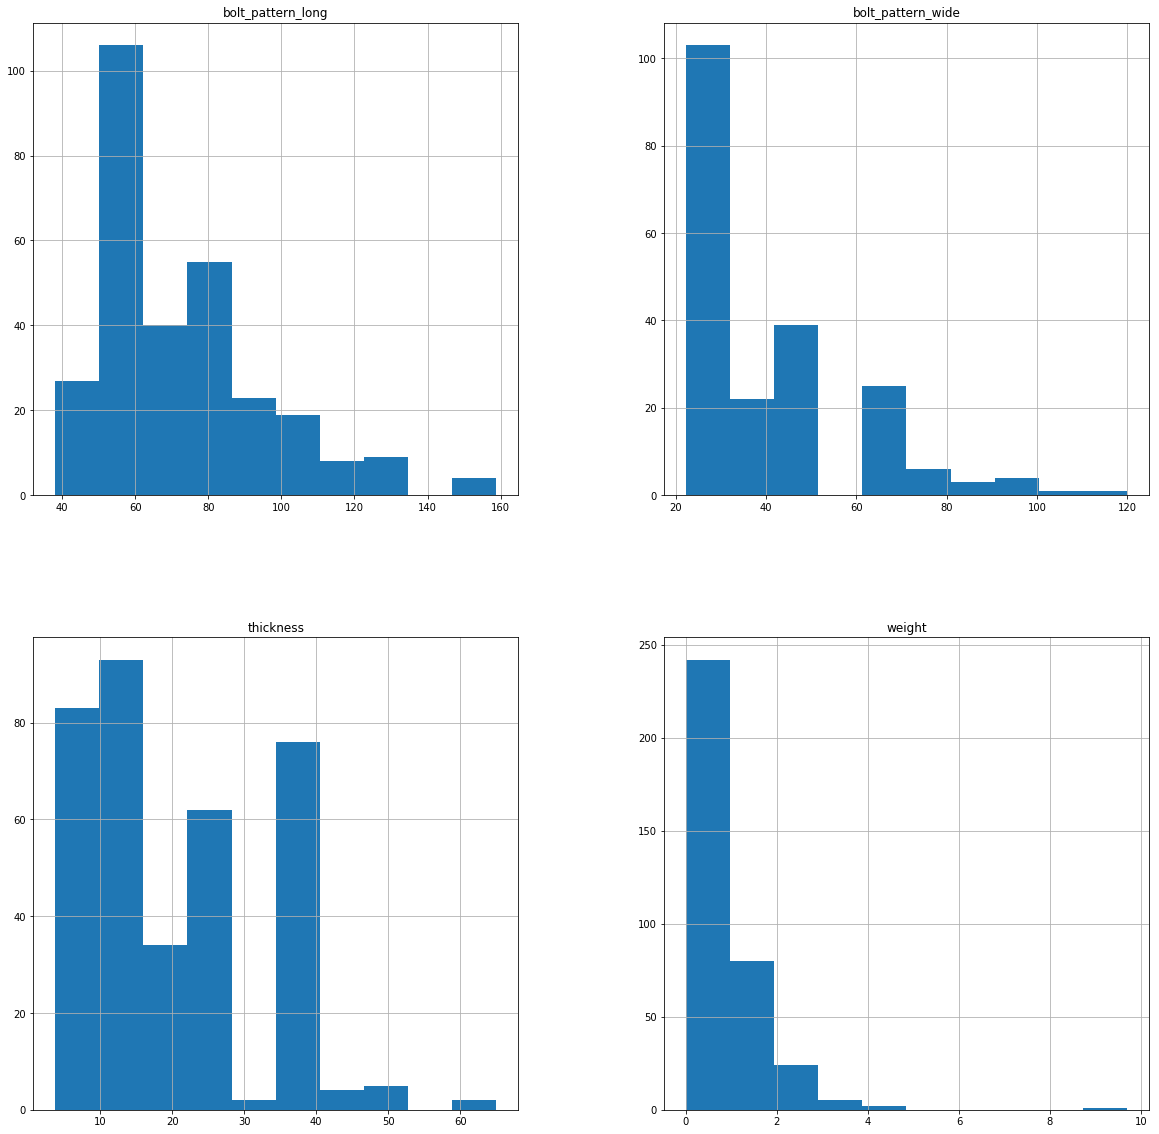

In [38]:
comp_straight.hist(figsize=(20,20))
plt.show()

In [40]:
#outlier detection through IQR proximity rule as the distribution is skewed

for i in comp_straight.columns:
    if comp_straight[i].dtype != object:
        IQR = comp_straight[i].quantile(0.75)-comp_straight[i].quantile(0.25)
        upperThres = comp_straight[i].quantile(0.75)+3*IQR
        
        if comp_straight[i][comp_straight[i] > upperThres].any() == True:
            print(i)
            print(comp_straight.loc[comp_straight[i] == comp_straight[i].max()])



weight
    component_id  bolt_pattern_long  bolt_pattern_wide  thickness  weight
171       C-1066               38.1                NaN       13.0   9.693


In [41]:
comp_tee.head()

,component_id,component_type_id,bolt_pattern_long,bolt_pattern_wide,extension_length,overall_length,thickness,drop_length,mj_class_code,mj_plug_class_code,groove,unique_feature,orientation,weight
0,C-0271,OTHER,58.70,30.20,57.10,93.0,57,28.5,MJ-003,Threaded,No,No,Yes,1.526
1,C-1809,OTHER,58.72,30.18,57.09,108.0,57,28.5,MJ-003,MJ-005,No,No,Yes,2.184
2,C-1830,OTHER,52.40,26.20,43.50,78.5,51,25.5,MJ-003,Threaded,No,Yes,Yes,1.135
3,C-1865,OTHER,58.70,30.20,57.10,107.0,57,28.5,MJ-003,MJ-005,No,No,Yes,1.953


In [42]:
comp_tee.drop(['component_type_id', 'mj_class_code', 'mj_plug_class_code', 'groove', 'unique_feature', 'orientation'],
              axis=1, inplace=True)
comp_tee

,component_id,bolt_pattern_long,bolt_pattern_wide,extension_length,overall_length,thickness,drop_length,weight
0,C-0271,58.70,30.20,57.10,93.0,57,28.5,1.526
1,C-1809,58.72,30.18,57.09,108.0,57,28.5,2.184
2,C-1830,52.40,26.20,43.50,78.5,51,25.5,1.135
3,C-1865,58.70,30.20,57.10,107.0,57,28.5,1.953


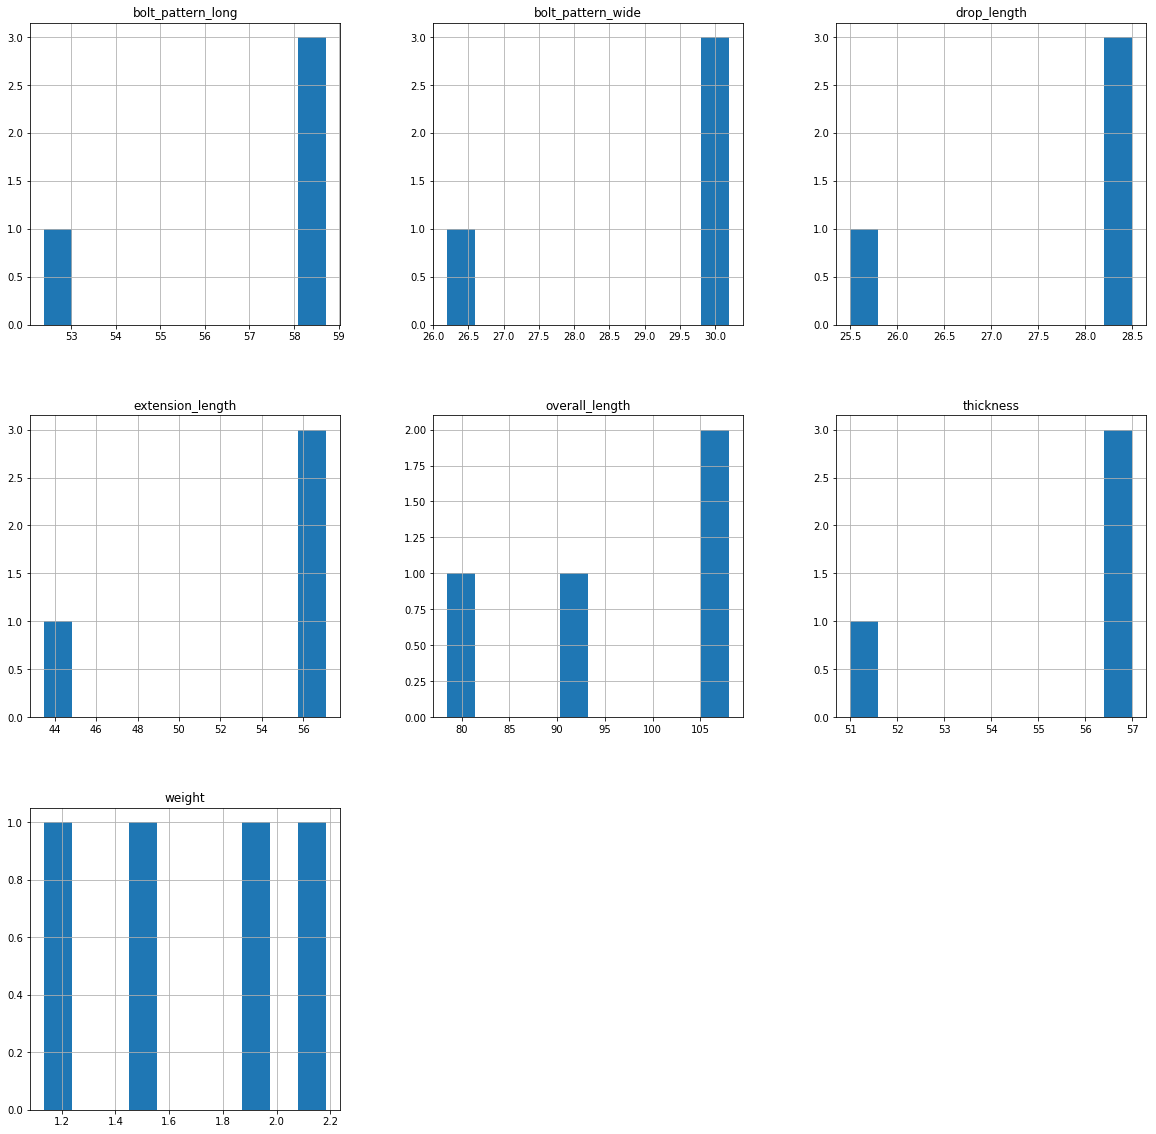

In [43]:
comp_tee.hist(figsize=(20,20))
plt.show()

In [44]:
#outlier detection through IQR proximity rule as the distribution is skewed

for i in comp_tee.columns:
    if comp_tee[i].dtype != object:
        IQR = comp_tee[i].quantile(0.75)-comp_tee[i].quantile(0.25)
        upperThres = comp_tee[i].quantile(0.75)+3*IQR
        
        if comp_tee[i][comp_tee[i] > upperThres].any() == True:
            print(i)
            print(comp_tee.loc[comp_tee[i] == comp_tee[i].max()])



In [45]:
comp_threaded.head()

,component_id,component_type_id,adaptor_angle,overall_length,hex_size,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,...,nominal_size_3,end_form_id_4,connection_type_id_4,length_4,thread_size_4,thread_pitch_4,nominal_size_4,unique_feature,orientation,weight
0,C-0007,CP-014,NaN,24.4,12.70,A-001,B-001,NaN,0.437,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0.028
1,C-0030,CP-015,90.0,NaN,NaN,A-003,NaN,47.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,0.914
2,C-0041,CP-014,NaN,28.0,32.00,A-004,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0.120
3,C-0043,CP-014,NaN,38.0,27.00,A-003,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0.090
4,C-0044,CP-014,NaN,30.5,41.28,A-004,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0.182


In [46]:
comp_threaded.drop(['component_type_id', 'adaptor_angle', 'end_form_id_1', 'connection_type_id_1', 'end_form_id_2',
                    'connection_type_id_2', 'end_form_id_3', 'connection_type_id_3', 'end_form_id_4', 'connection_type_id_4',
                    'nominal_size_4', 'unique_feature', 'orientation'], axis=1, inplace=True)
comp_threaded.head()

,component_id,overall_length,hex_size,length_1,thread_size_1,thread_pitch_1,nominal_size_1,length_2,thread_size_2,thread_pitch_2,nominal_size_2,length_3,thread_size_3,thread_pitch_3,nominal_size_3,length_4,thread_size_4,thread_pitch_4,weight
0,C-0007,24.4,12.70,NaN,0.437,20.0,NaN,NaN,NaN,NaN,6.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028
1,C-0030,NaN,NaN,47.0,NaN,NaN,42,47.0,NaN,NaN,42.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.914
2,C-0041,28.0,32.00,NaN,NaN,NaN,21.7,NaN,0.812,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.120
3,C-0043,38.0,27.00,NaN,NaN,NaN,21.7,NaN,0.812,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090
4,C-0044,30.5,41.28,NaN,NaN,NaN,34,NaN,1.437,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.182


In [47]:
#There are five columns with length. So I fill NA with 0, summarize length and drop excessive columns.
comp_threaded['length_1'] = comp_threaded['length_1'].fillna(0)
comp_threaded['length_2'] = comp_threaded['length_2'].fillna(0)
comp_threaded['length_3'] = comp_threaded['length_3'].fillna(0)
comp_threaded['length_4'] = comp_threaded['length_4'].fillna(0)
comp_threaded['overall_length'] = comp_threaded['overall_length'].fillna(0)
comp_threaded['overall_length'] = comp_threaded['overall_length'] + comp_threaded['length_1'] + comp_threaded['length_2'] + comp_threaded['length_3'] + comp_threaded['length_4']

comp_threaded.drop(['length_1', 'length_2', 'length_3', 'length_4'], axis=1, inplace=True)

comp_threaded.head()

,component_id,overall_length,hex_size,thread_size_1,thread_pitch_1,nominal_size_1,thread_size_2,thread_pitch_2,nominal_size_2,thread_size_3,thread_pitch_3,nominal_size_3,thread_size_4,thread_pitch_4,weight
0,C-0007,24.4,12.70,0.437,20.0,NaN,NaN,NaN,6.35,NaN,NaN,NaN,NaN,NaN,0.028
1,C-0030,94.0,NaN,NaN,NaN,42,NaN,NaN,42.00,NaN,NaN,NaN,NaN,NaN,0.914
2,C-0041,28.0,32.00,NaN,NaN,21.7,0.812,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.120
3,C-0043,38.0,27.00,NaN,NaN,21.7,0.812,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.090
4,C-0044,30.5,41.28,NaN,NaN,34,1.437,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0.182


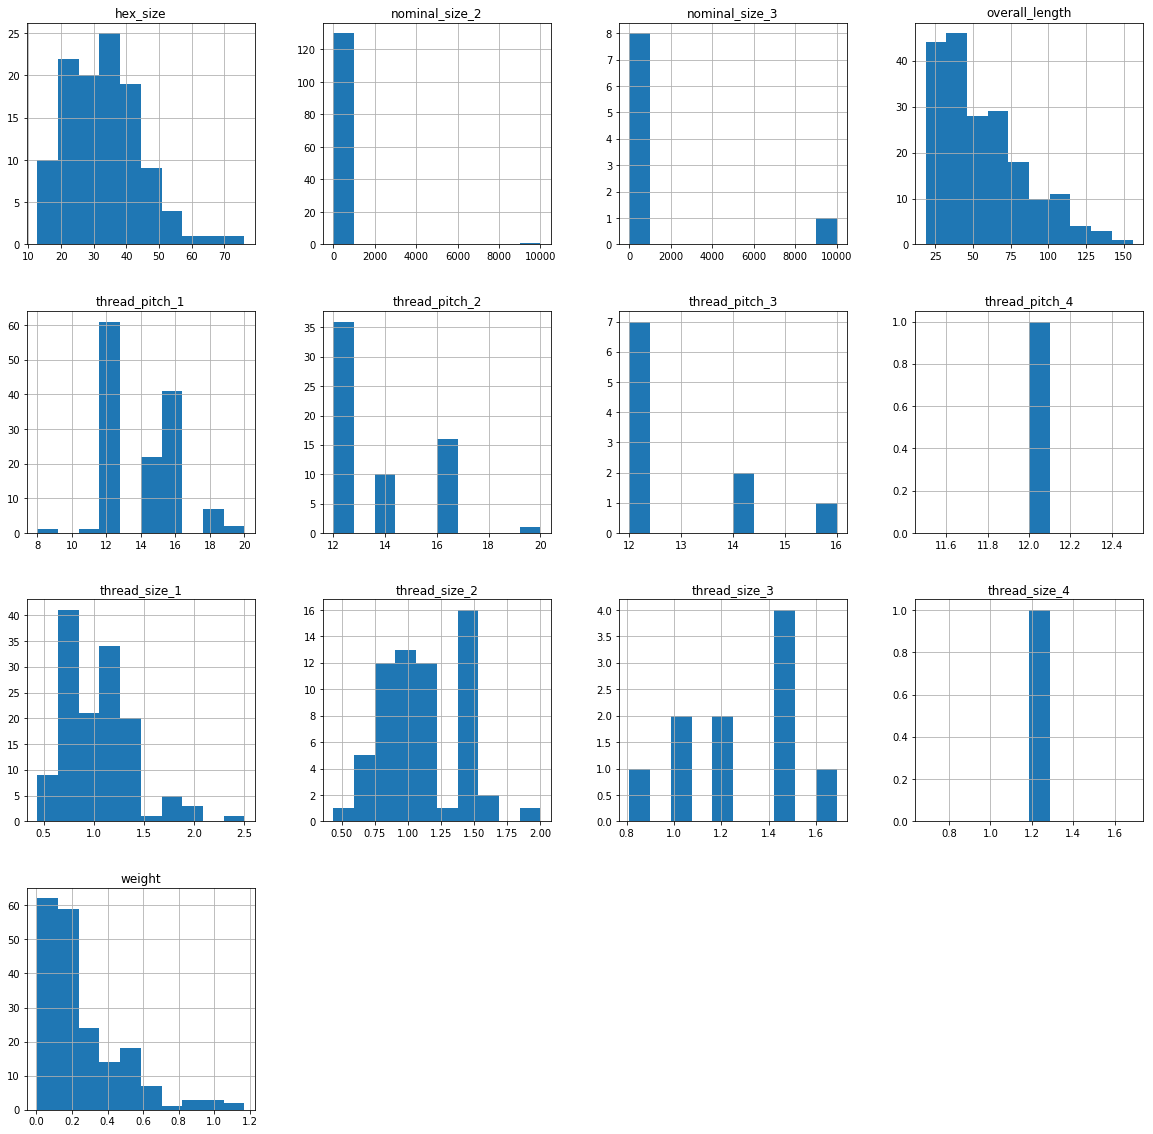

In [48]:
comp_threaded.hist(figsize=(20,20))
plt.show()

In [49]:
#outlier detection through IQR proximity rule as the distribution is skewed

for i in comp_threaded.columns:
    if comp_threaded[i].dtype != object:
        IQR = comp_threaded[i].quantile(0.75)-comp_threaded[i].quantile(0.25)
        upperThres = comp_threaded[i].quantile(0.75)+3*IQR
        
        if comp_threaded[i][comp_threaded[i] > upperThres].any() == True:
            print(i)
            print(comp_threaded.loc[comp_threaded[i] == comp_threaded[i].max()])



thread_size_1
   component_id  overall_length  hex_size  thread_size_1  thread_pitch_1  \
67       C-0651            72.4      76.2            2.5             8.0   

   nominal_size_1  thread_size_2  thread_pitch_2  nominal_size_2  \
67            NaN            NaN             NaN            63.5   

    thread_size_3  thread_pitch_3  nominal_size_3  thread_size_4  \
67            NaN             NaN             NaN            NaN   

    thread_pitch_4  weight  
67             NaN   0.968  
nominal_size_2
   component_id  overall_length  hex_size  thread_size_1  thread_pitch_1  \
40       C-0386            42.7      60.3            2.0            12.0   

   nominal_size_1  thread_size_2  thread_pitch_2  nominal_size_2  \
40            NaN            NaN             NaN          9999.0   

    thread_size_3  thread_pitch_3  nominal_size_3  thread_size_4  \
40            NaN             NaN             NaN            NaN   

    thread_pitch_4  weight  
40             NaN   0.543  
n

In [50]:
comp_threaded.drop(comp_threaded.index[[40, 90]], inplace=True)

In [51]:
tube.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [56]:
tube.drop(['material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other'],
          axis=1, inplace=True)
tube.head()

,tube_assembly_id,diameter,wall,length,num_bends,bend_radius
0,TA-00001,12.70,1.65,164.0,5,38.10
1,TA-00002,6.35,0.71,137.0,8,19.05
2,TA-00003,6.35,0.71,127.0,7,19.05
3,TA-00004,6.35,0.71,137.0,9,19.05
4,TA-00005,19.05,1.24,109.0,4,50.80


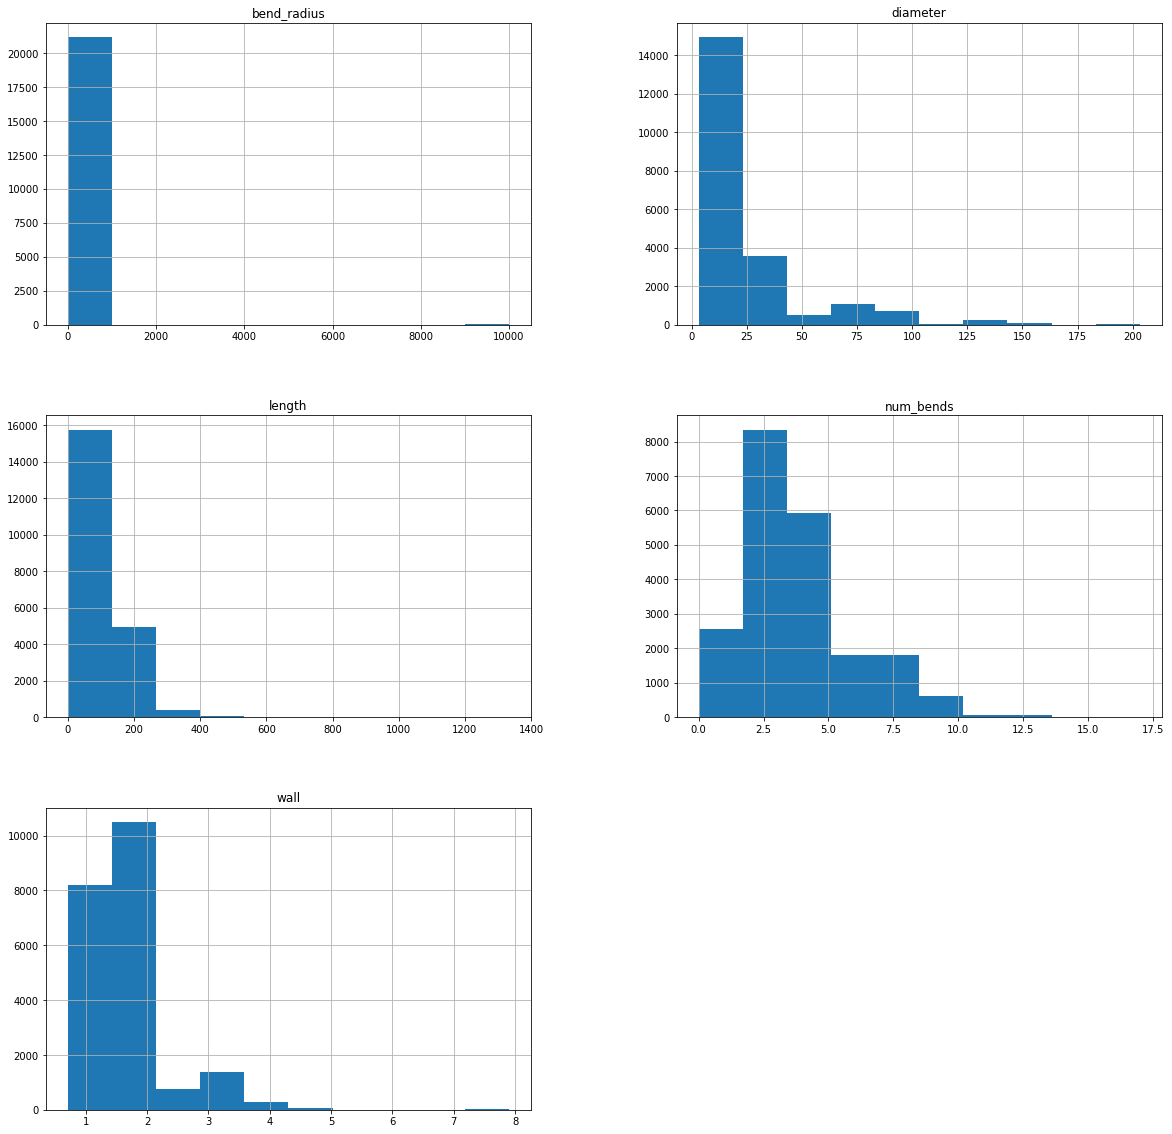

In [57]:
tube.hist(figsize=(20,20))
plt.show()

In [59]:
#outlier detection through IQR proximity rule as the distribution is skewed

for i in tube.columns:
    if tube[i].dtype != object:
        IQR = tube[i].quantile(0.75)-tube[i].quantile(0.25)
        upperThres = tube[i].quantile(0.75)+3*IQR
        
        if tube[i][tube[i] > upperThres].any() == True:
            print(i)
            print(tube.loc[tube[i] == tube[i].max()])



diameter
      tube_assembly_id  diameter  wall  length  num_bends  bend_radius
11306         TA-11307     203.2   1.9    62.0          0          0.0
11309         TA-11310     203.2   1.9    48.0          0          0.0
11341         TA-11342     203.2   1.9    40.0          0          0.0
13049         TA-13050     203.2   1.9    70.0          0          0.0
14709         TA-14710     203.2   1.9    64.0          0          0.0
15619         TA-15620     203.2   1.9    26.0          0          0.0
16762         TA-16763     203.2   1.9   129.0          2        203.2
17421         TA-17422     203.2   1.9    22.0          0          0.0
wall
      tube_assembly_id  diameter  wall  length  num_bends  bend_radius
389           TA-00390      66.7   7.9   310.0          2       177.80
390           TA-00391      66.7   7.9   393.0          2       177.80
391           TA-00392      66.7   7.9   174.0          2       177.80
392           TA-00393      66.7   7.9   188.0          2      

In [60]:
tube.drop(tube.index[[17689,17689,18002,18003,15132, 15174, 15175, 17688, 17689, 18002, 18003, 19320]], inplace=True)

In [61]:


# below  files contain only has text descriptions, so I decided not to use them:

# tube_end_form

# type_component

# type_connection

# type_end_form

# components

components.head()

,component_id,name,component_type_id
0,9999,OTHER,OTHER
1,C-0001,SLEEVE,CP-024
2,C-0002,SLEEVE,CP-024
3,C-0003,SLEEVE-FLARED,CP-024
4,C-0004,NUT,CP-026


# Data Preparation

In [62]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [63]:
#Create several features from dates for additional information.
train['year'] = train.quote_date.dt.year
train['month'] = train.quote_date.dt.month
train['dayofyear'] = train.quote_date.dt.dayofyear
train['dayofweek'] = train.quote_date.dt.dayofweek
train['day'] = train.quote_date.dt.day

test['year'] = test.quote_date.dt.year
test['month'] = test.quote_date.dt.month
test['dayofyear'] = test.quote_date.dt.dayofyear
test['dayofweek'] = test.quote_date.dt.dayofweek
test['day'] = test.quote_date.dt.day

train = train.drop('quote_date',axis=1)
test = test.drop('quote_date',axis=1)

In [64]:
train.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,year,month,dayofyear,dayofweek,day
0,TA-00002,S-0066,0,0,Yes,1,21.905933,2013,7,188,6,7
1,TA-00002,S-0066,0,0,Yes,2,12.341214,2013,7,188,6,7
2,TA-00002,S-0066,0,0,Yes,5,6.601826,2013,7,188,6,7
3,TA-00002,S-0066,0,0,Yes,10,4.687770,2013,7,188,6,7
4,TA-00002,S-0066,0,0,Yes,25,3.541561,2013,7,188,6,7


In [65]:
#I combine all files with info on components in one file.
all_comp = pd.concat([comp_adaptor, comp_boss, comp_elbow, comp_float, comp_hfl, comp_nut, comp_other,
                      comp_sleeve, comp_straight, comp_tee, comp_threaded])

all_comp.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,bolt_pattern_long,bolt_pattern_wide,component_id,drop_length,elbow_angle,extension_length,height_over_tube,hex_nut_size,hex_size,hose_diameter,...,thread_pitch_1,thread_pitch_2,thread_pitch_3,thread_pitch_4,thread_size,thread_size_1,thread_size_2,thread_size_3,thread_size_4,weight
0,NaN,NaN,C-0005,NaN,NaN,NaN,NaN,NaN,34.93,NaN,...,12.0,11.5,NaN,NaN,NaN,1.312,1.000,NaN,NaN,0.206
1,NaN,NaN,C-0006,NaN,NaN,NaN,NaN,NaN,22.20,NaN,...,20.0,16.0,NaN,NaN,NaN,0.437,0.750,NaN,NaN,0.083
2,NaN,NaN,C-1435,NaN,NaN,NaN,NaN,NaN,22.22,NaN,...,NaN,18.0,NaN,NaN,NaN,NaN,0.875,NaN,NaN,0.023
3,NaN,NaN,C-1546,NaN,NaN,NaN,NaN,NaN,15.88,NaN,...,27.0,27.0,NaN,NaN,NaN,0.125,0.125,NaN,NaN,0.026
4,NaN,NaN,C-1583,NaN,NaN,NaN,NaN,NaN,38.10,NaN,...,12.0,12.0,NaN,NaN,NaN,1.312,1.062,NaN,NaN,0.256


In [66]:
all_comp.shape

(2033, 29)

In [67]:
all_comp.isnull().sum()

bolt_pattern_long      1552
bolt_pattern_wide      1671
component_id              0
drop_length            1859
elbow_angle            1904
extension_length       1860
height_over_tube       1887
hex_nut_size           1991
hex_size               1907
hose_diameter          2027
intended_nut_pitch     1991
intended_nut_thread    1991
length                 1926
nominal_size_1         1966
nominal_size_2         1901
nominal_size_3         2025
overall_length         1640
thickness              1482
thread_pitch           1968
thread_pitch_1         1884
thread_pitch_2         1950
thread_pitch_3         2023
thread_pitch_4         2032
thread_size            1968
thread_size_1          1884
thread_size_2          1950
thread_size_3          2023
thread_size_4          2032
weight                   69
dtype: int64

In [68]:
all_comp = all_comp[['component_id', 'weight', 'length', 'overall_length', 'thickness']]
all_comp.head()

,component_id,weight,length,overall_length,thickness
0,C-0005,0.206,NaN,58.4,NaN
1,C-0006,0.083,NaN,34.8,NaN
2,C-1435,0.023,NaN,20.3,NaN
3,C-1546,0.026,NaN,26.4,NaN
4,C-1583,0.256,NaN,44.5,NaN


In [69]:


#Combine two length columns.
all_comp['overall_length'] = all_comp['overall_length'].fillna(0)
all_comp['length'] = all_comp['length'].fillna(0)
all_comp['length'] = all_comp['length'] + all_comp['overall_length']
all_comp = all_comp.drop(['overall_length'], axis=1)

all_comp['weight'] = all_comp['weight'].fillna(0)
all_comp['thickness'] = all_comp['thickness'].fillna(0)

all_comp.head()

,component_id,weight,length,thickness
0,C-0005,0.206,58.4,0.0
1,C-0006,0.083,34.8,0.0
2,C-1435,0.023,20.3,0.0
3,C-1546,0.026,26.4,0.0
4,C-1583,0.256,44.5,0.0


In [70]:
#Add information about tube itself and the list of components to main files.
train = pd.merge(train, tube, on='tube_assembly_id', how='left')
train = pd.merge(train, bill_of_materials, on ='tube_assembly_id', how='left')
print(train.shape)
test = pd.merge(test, tube, on='tube_assembly_id', how='left')
test = pd.merge(test, bill_of_materials, on ='tube_assembly_id', how='left')
print(test.shape)

(30213, 33)
(30235, 33)


In [71]:
#Rename columns so that they will be different from length of components.
train.rename(columns={'length': 'length_t'}, inplace = True)
test.rename(columns={'length': 'length_t'}, inplace = True)

In [72]:
#Merging to get information about components
for i in range(1, 9, 2):
    suffix1 = '_' + str(i)
    suffix2 = '_' + str(i + 1)
    component_1 = 'component_id' + suffix1
    component_2 = 'component_id' + suffix2
    
    train = pd.merge(train, all_comp, left_on = component_1, right_on = 'component_id', how='left')
    train = pd.merge(train, all_comp, left_on = component_2, right_on = 'component_id', suffixes=(suffix1, suffix2), how='left')
    
    test = pd.merge(test, all_comp, left_on = component_1, right_on = 'component_id', how='left')
    test = pd.merge(test, all_comp, left_on = component_2, right_on = 'component_id', suffixes=(suffix1, suffix2), how='left')

In [73]:
train.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,year,month,dayofyear,...,length_6,thickness_6,component_id_7,weight_7,length_7,thickness_7,component_id_8,weight_8,length_8,thickness_8
0,TA-00002,S-0066,0,0,Yes,1,21.905933,2013,7,188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,S-0066,0,0,Yes,2,12.341214,2013,7,188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00002,S-0066,0,0,Yes,5,6.601826,2013,7,188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00002,S-0066,0,0,Yes,10,4.687770,2013,7,188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00002,S-0066,0,0,Yes,25,3.541561,2013,7,188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
print(train.shape)
train.isnull().sum()

(30213, 65)


tube_assembly_id          0
supplier                  0
annual_usage              0
min_order_quantity        0
bracket_pricing           0
quantity                  0
cost                      0
year                      0
month                     0
dayofyear                 0
dayofweek                 0
day                       0
diameter                 12
wall                     12
length_t                 12
num_bends                12
bend_radius              12
component_id_1         1462
quantity_1             1462
component_id_2         9129
quantity_2             9129
component_id_3        23058
quantity_3            23042
component_id_4        29426
quantity_4            29426
component_id_5        30147
quantity_5            30147
component_id_6        30185
quantity_6            30185
component_id_7        30205
quantity_7            30205
component_id_8        30210
quantity_8            30210
component_id_1         1921
weight_1               1921
length_1            

In [77]:
#Drop unnecessary columns
train.drop(['component_id_1', 'component_id_2', 'component_id_3', 'component_id_4', 'component_id_5', 'component_id_6',
            'component_id_7', 'component_id_8'], axis=1, inplace=True)
test.drop(['component_id_1', 'component_id_2', 'component_id_3', 'component_id_4', 'component_id_5', 'component_id_6',
            'component_id_7', 'component_id_8'], axis=1, inplace=True)
train.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,year,month,dayofyear,dayofweek,day,diameter,wall,length_t,num_bends,bend_radius,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8,weight_1,length_1,thickness_1,weight_2,length_2,thickness_2,weight_3,length_3,thickness_3,weight_4,length_4,thickness_4,weight_5,length_5,thickness_5,weight_6,length_6,thickness_6,weight_7,length_7,thickness_7,weight_8,length_8,thickness_8
0,TA-00002,S-0066,0,0,Yes,1,21.905933,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,S-0066,0,0,Yes,2,12.341214,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00002,S-0066,0,0,Yes,5,6.601826,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00002,S-0066,0,0,Yes,10,4.687770,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00002,S-0066,0,0,Yes,25,3.541561,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
#Add descriptive information about specs.
train = pd.merge(train, specs, on='tube_assembly_id', how='left')
test = pd.merge(test, specs, on='tube_assembly_id', how='left')

In [79]:
train.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,year,month,dayofyear,dayofweek,day,diameter,wall,length_t,num_bends,bend_radius,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8,weight_1,length_1,thickness_1,weight_2,length_2,thickness_2,weight_3,length_3,thickness_3,weight_4,length_4,thickness_4,weight_5,length_5,thickness_5,weight_6,length_6,thickness_6,weight_7,length_7,thickness_7,weight_8,length_8,thickness_8,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
0,TA-00002,S-0066,0,0,Yes,1,21.905933,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,S-0066,0,0,Yes,2,12.341214,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00002,S-0066,0,0,Yes,5,6.601826,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00002,S-0066,0,0,Yes,10,4.687770,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00002,S-0066,0,0,Yes,25,3.541561,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
#Calculate various additional features on physical parameters. They turned out to be useful.
length_columns = [col for col in list(train.columns) if 'length' in col]
weight_columns = [col for col in list(train.columns) if 'weight' in col]
thickness_columns = [col for col in list(train.columns) if 'thickness' in col]
train['avg_w'] = train[weight_columns].mean(axis=1)
train['avg_l'] = train[length_columns].mean(axis=1)
train['avg_th'] = train[thickness_columns].mean(axis=1)
train['min_w'] = train[weight_columns].min(axis=1)
train['min_l'] = train[length_columns].min(axis=1)
train['min_th'] = train[thickness_columns].min(axis=1)
train['max_w'] = train[weight_columns].max(axis=1)
train['max_l'] = train[length_columns].max(axis=1)
train['max_th'] = train[thickness_columns].max(axis=1)
test['avg_w'] = test[weight_columns].mean(axis=1)
test['avg_l'] = test[length_columns].mean(axis=1)
test['avg_th'] = test[thickness_columns].mean(axis=1)
test['min_w'] = test[weight_columns].min(axis=1)
test['min_l'] = test[length_columns].min(axis=1)
test['min_th'] = test[thickness_columns].min(axis=1)
test['max_w'] = test[weight_columns].max(axis=1)
test['max_l'] = test[length_columns].max(axis=1)
test['max_th'] = test[thickness_columns].max(axis=1)
train['tot_w'] = train[weight_columns].sum(axis=1)
train['tot_l'] = train[length_columns].sum(axis=1)
test['tot_w'] = test[weight_columns].sum(axis=1)
test['tot_l'] = test[length_columns].sum(axis=1)

In [81]:
train.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,year,month,dayofyear,dayofweek,day,diameter,wall,length_t,num_bends,bend_radius,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8,weight_1,length_1,thickness_1,weight_2,length_2,thickness_2,weight_3,length_3,thickness_3,weight_4,length_4,thickness_4,weight_5,length_5,thickness_5,weight_6,length_6,thickness_6,weight_7,length_7,thickness_7,weight_8,length_8,thickness_8,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10,avg_w,avg_l,avg_th,min_w,min_l,min_th,max_w,max_l,max_th,tot_w,tot_l
0,TA-00002,S-0066,0,0,Yes,1,21.905933,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.009,151.2
1,TA-00002,S-0066,0,0,Yes,2,12.341214,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.009,151.2
2,TA-00002,S-0066,0,0,Yes,5,6.601826,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.009,151.2
3,TA-00002,S-0066,0,0,Yes,10,4.687770,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.009,151.2
4,TA-00002,S-0066,0,0,Yes,25,3.541561,2013,7,188,6,7,6.35,0.71,137.0,8.0,19.05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,14.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.009,151.2


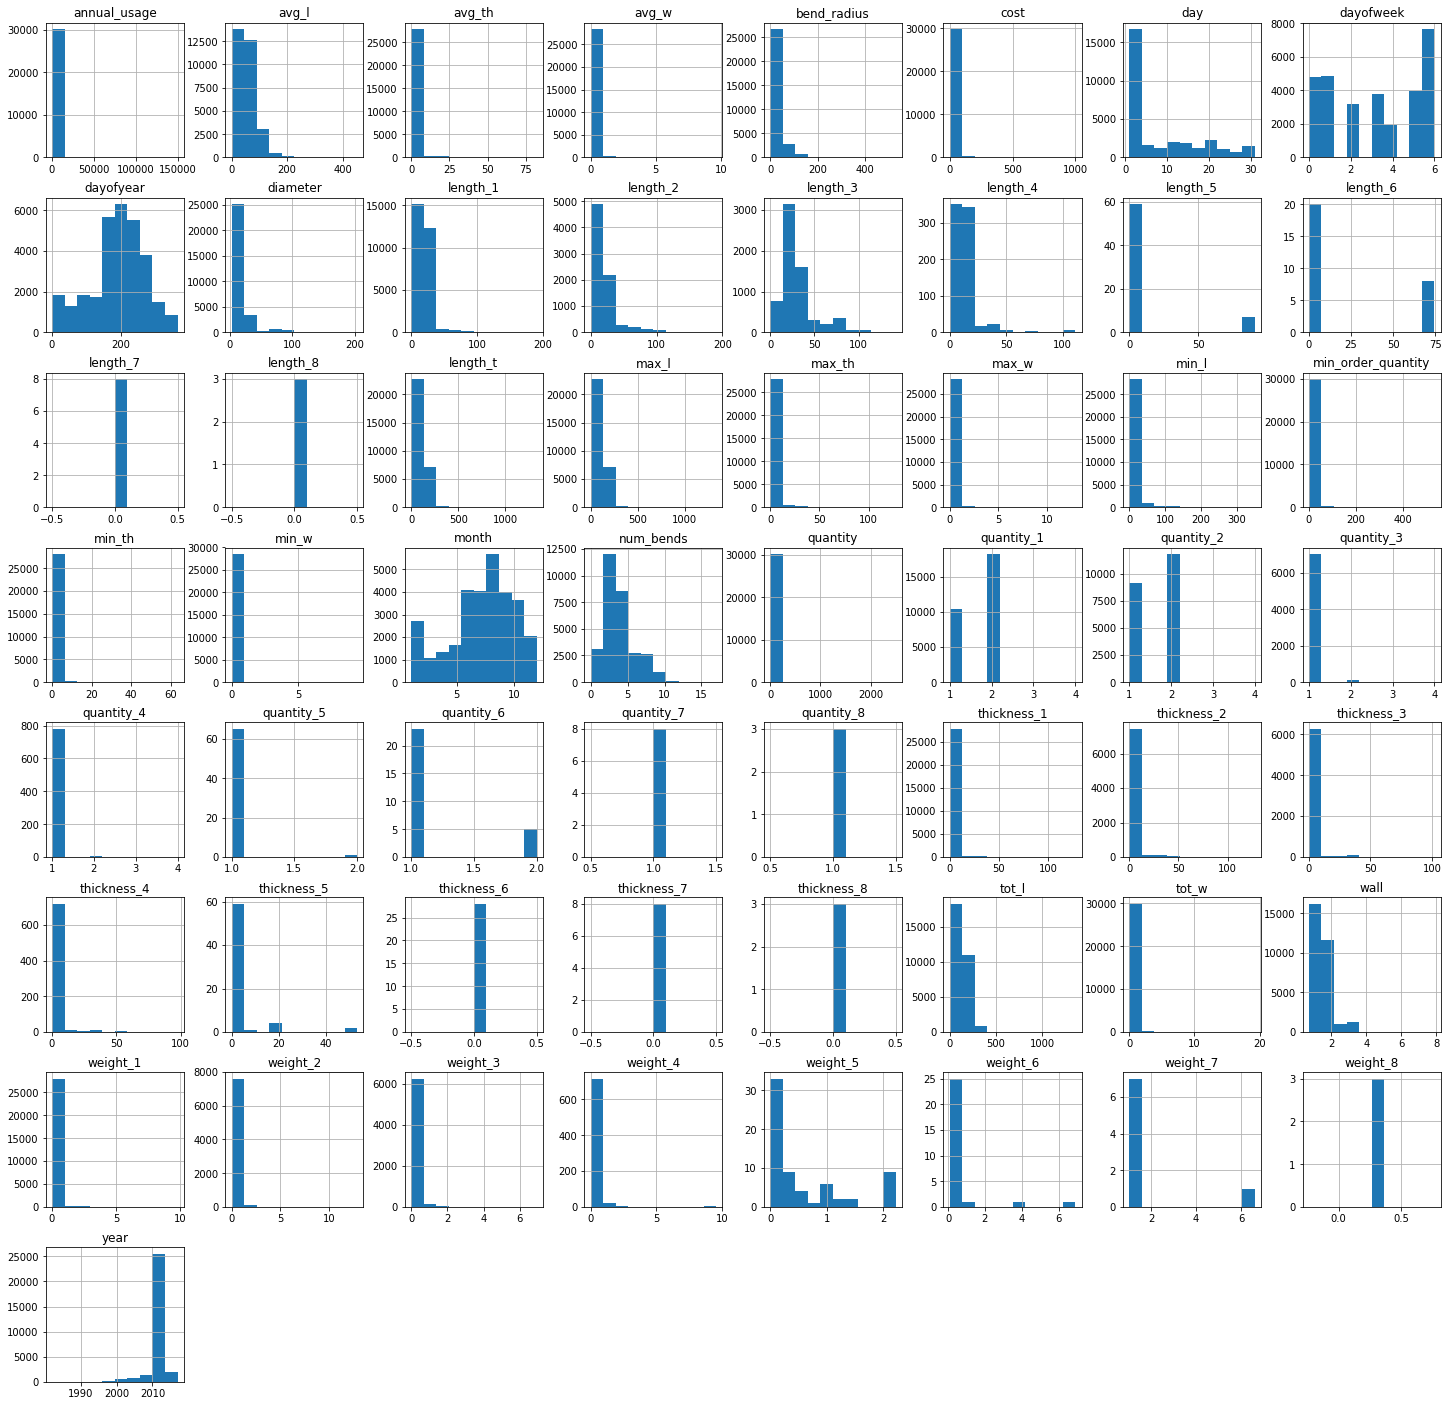

In [88]:
feat_name= [col for col in train.columns if train[col].dtype != 'object']
train[feat_name].hist(figsize=(25,25))
plt.show()

In [89]:
#Take log of skewered columns to smooth them and fill NA.
for col in train.columns:
    if train[col].dtype != 'object':
        if skew(train[col]) > 0.75:
            train[col] = np.log1p(train[col])
            train[col] = train[col].apply(lambda x: 0 if x == -np.inf else x)

        train[col] = train[col].fillna(0)
        
for col in test.columns:
    if test[col].dtype != 'object':
        if skew(test[col]) > 0.75:
            test[col] = np.log1p(test[col])
            test[col] = test[col].apply(lambda x: 0 if x == -np.inf else x)

        test[col] = test[col].fillna(0)

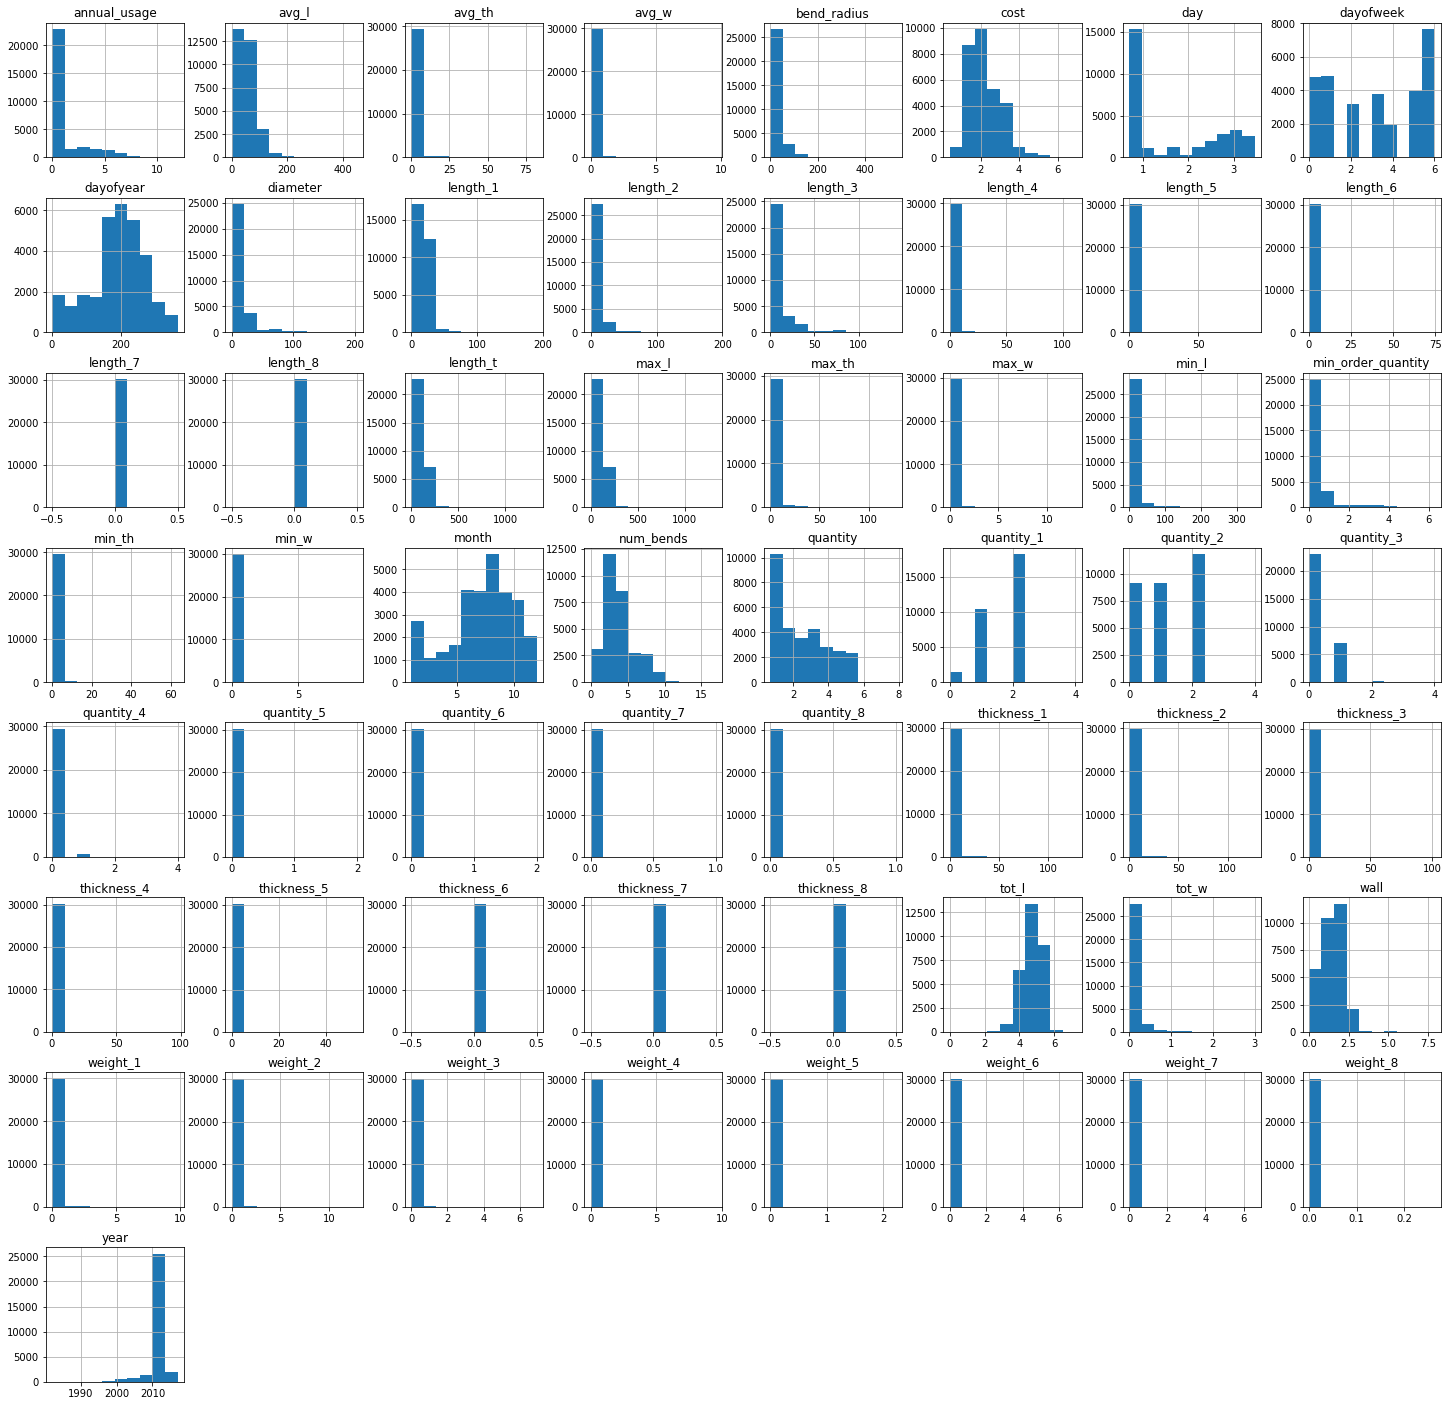

In [90]:
feat_name= [col for col in train.columns if train[col].dtype != 'object']
train[feat_name].hist(figsize=(25,25))
plt.show()

In [91]:
for col in train.columns:
    if train[col].dtype == 'object':
        train[col].replace(np.nan,' ', regex=True, inplace= True)
for col in test.columns:
    if test[col].dtype == 'object':
        test[col].replace(np.nan,' ', regex=True, inplace= True)

In [100]:
train.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,year,month,dayofyear,dayofweek,day,diameter,wall,length_t,num_bends,bend_radius,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8,weight_1,length_1,thickness_1,weight_2,length_2,thickness_2,weight_3,length_3,thickness_3,weight_4,length_4,thickness_4,weight_5,length_5,thickness_5,weight_6,length_6,thickness_6,weight_7,length_7,thickness_7,weight_8,length_8,thickness_8,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10,avg_w,avg_l,avg_th,min_w,min_l,min_th,max_w,max_l,max_th,tot_w,tot_l
0,TA-00002,S-0066,0.0,0.0,Yes,0.693147,3.131396,2013,7,188,6,2.079442,6.35,0.71,137.0,8.0,19.05,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,14.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,,,,,,,,,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.00896,5.025195
1,TA-00002,S-0066,0.0,0.0,Yes,1.098612,2.590858,2013,7,188,6,2.079442,6.35,0.71,137.0,8.0,19.05,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,14.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,,,,,,,,,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.00896,5.025195
2,TA-00002,S-0066,0.0,0.0,Yes,1.791759,2.028389,2013,7,188,6,2.079442,6.35,0.71,137.0,8.0,19.05,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,14.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,,,,,,,,,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.00896,5.025195
3,TA-00002,S-0066,0.0,0.0,Yes,2.397895,1.738318,2013,7,188,6,2.079442,6.35,0.71,137.0,8.0,19.05,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,14.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,,,,,,,,,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.00896,5.025195
4,TA-00002,S-0066,0.0,0.0,Yes,3.258097,1.513271,2013,7,188,6,2.079442,6.35,0.71,137.0,8.0,19.05,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,14.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,,,,,,,,,0.009,75.6,0.0,0.009,14.2,0.0,0.009,137.0,0.0,0.00896,5.025195


In [123]:
X_train = train.drop('cost',axis=1)
Y_train = train['cost']
X_test  = test.drop('id', axis=1)

In [124]:
X_train.shape,X_test.shape

((30213, 69), (30235, 69))

In [128]:
feat_name = [col for col in X_train.columns if X_train[col].dtypes == 'O']
feat_index = [X_train.columns.get_loc(c) for c in feat_name if c in X_train]
feat_name,feat_index

(['tube_assembly_id',
  'supplier',
  'bracket_pricing',
  'spec1',
  'spec2',
  'spec3',
  'spec4',
  'spec5',
  'spec6',
  'spec7',
  'spec8',
  'spec9',
  'spec10'],
 [0, 1, 4, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57])

In [129]:
#Convert to arrays for easier transformation
X_train = np.array(X_train)
X_test = np.array(X_test)

In [130]:
from sklearn.preprocessing import LabelEncoder

#label encoding

for i in feat_index:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(X_train[:,i]) + list(X_test[:,i]))
    X_train[:,i] = lbl.transform(X_train[:,i])
    X_test[:,i] = lbl.transform(X_test[:,i])



In [131]:
X_train

array([[1, 41, 0.0, ..., 0.0, 0.008959741371471906, 5.025195445427586],
       [1, 41, 0.0, ..., 0.0, 0.008959741371471906, 5.025195445427586],
       [1, 41, 0.0, ..., 0.0, 0.008959741371471906, 5.025195445427586],
       ...,
       [17706, 27, 0.6931471805599453, ..., 12.0, 0.11154137473290743,
        4.465908118654584],
       [17707, 39, 6.0473721790462776, ..., 0.0, 0.0, 3.912023005428146],
       [17708, 17, 1.3862943611198906, ..., 28.4, 0.21913552991667093,
        4.328098292648326]], dtype=object)

In [132]:
#XGB need float.
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Model Building and Evaluation

In [134]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.20, random_state=10)
print()
print('Training Data Size :',x_train.shape)
print('Test Data Size :',x_test.shape)
print('Training Label Size :',y_train.shape)
print('Testing Label Size :',y_test.shape)


Training Data Size : (24170, 69)
Test Data Size : (6043, 69)
Training Label Size : (24170,)
Testing Label Size : (6043,)


In [135]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param ={
            'n_estimators': [100,500, 1000,1500],
            'max_depth':[2,4,6,8]
        }

xgboost_tree = xgb.XGBRegressor(
    eta = 0.1,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)

grid = GridSearchCV(estimator=xgboost_tree,param_grid=param,cv=5,  verbose=10, n_jobs=-1,scoring='neg_mean_squared_error')
   
    

    
grid_result = grid.fit(x_train, y_train)
best_params = grid_result.best_params_

print('Best Params :',best_params)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:  5.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  75 out of  80 | elapsed:  6.7min remaining:   26.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.6min finished
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Params : {'max_depth': 6, 'n_estimators': 1500}


In [144]:
from math import sqrt
from sklearn.metrics import mean_squared_error

pred = grid_result.predict(x_test)
print('Root Mean squared error {}'.format(sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))))

Root Mean squared error 11.93572536545


In [150]:

diff = pd.concat([np.exp(y_test).reset_index(drop='True'),pd.DataFrame(np.exp(pred)).reset_index(drop='True')],axis=1)
diff.columns = ['Orginal','Prediction']
diff['Diff'] = diff.Orginal - diff.Prediction
diff.head()

,Orginal,Prediction,Diff
0,7.841083,7.767810,0.073273
1,5.159178,3.395638,1.763541
2,10.200269,10.318551,-0.118282
3,333.088826,423.129791,-90.040966
4,25.685210,27.804110,-2.118900
